In [1]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, Catlab.WiringDiagrams, Catlab.Graphics
using AlgebraicPetri
using AlgebraicDynamics.UWDDynam, AlgebraicDynamics.DWDDynam
using LabelledArrays
using OrdinaryDiffEq, DelayDiffEq, DifferentialEquations # This is from SciML
using Plots
using JSON: parse as parse_json

## Compartmental Covid Model
https://www.sciencedirect.com/science/article/pii/S0960077921000424

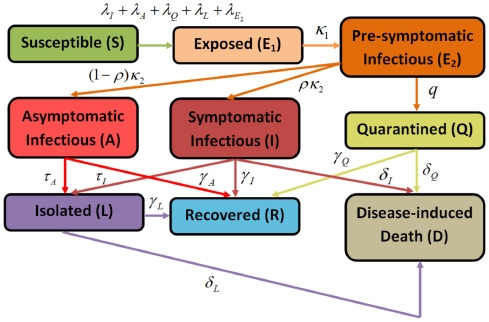

In this model, The susceptible compartment can only ever decrease in size (ignores the fact of Covid reinfection).

`Isolated = Hospitalized` Isolation separates sick people with a contagious disease from people who are not sick. Quarantine separates and restricts the movement of people who were exposed to a contagious disease to see if they become sick. Isolation is for people who are already sick.

https://www.cdc.gov/quarantine/index.html

### Next steps
These changes would be hard to do without rewriting the differential equations and recreating the.
- Allow recovered people to return to susceptible people to return to Recovered State
- Remove quarantine compartment. Exposure to Quarantine is no longer relevant.

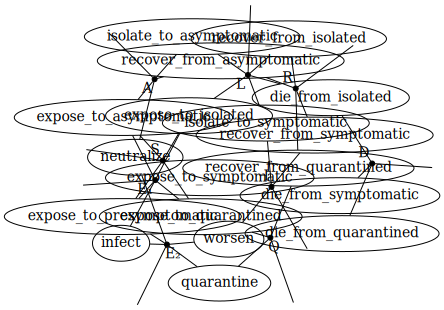

In [2]:
compartments = @relation (S, E₁, E₂, I, A, Q, L, R, D) begin
  expose_to_symptomatic(S, I, E₁)
  expose_to_asymptomatic(S, A, E₁)
  expose_to_quarantined(S, Q, E₁)
  expose_to_isolated(S, L, E₁)
  expose_to_presymptomatic(S, E₂, E₁)
  infect(E₁,E₂)
  neutralize(E₂, A)
  worsen(E₂, I)
  quarantine(E₂, Q)
  isolate_to_asymptomatic(A, L)
  isolate_to_symptomatic(I, L)
  recover_from_asymptomatic(A,R)
  recover_from_symptomatic(I,R)
  recover_from_quarantined(Q,R)
  recover_from_isolated(L,R)
  die_from_symptomatic(I,D)
  die_from_quarantined(Q,D)
  die_from_isolated(L,D)  
end

display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>".75"));

display_uwd(compartments)

In [3]:
#spontaneous_petri(x::Symbol, y::Symbol, z::Symbol)
#
#Generates an OpenLabelledPetriNet which represents a transition named `z` which
#changes a token from state `x` to state `y`.
spontaneous_petri(x::Symbol, y::Symbol, z::Symbol) = Open(LabelledPetriNet(unique([x,y]), z=>(x, y)))

#exposure_petri(x::Symbol, y::Symbol, z::Symbol, transition::Symbol)
#
#Generates an OpenLabelledPetriNet which represents an exposure transition where
#a token from state `y` "exposes" a token from state `x`, converting the token
#from state `x` to state `z`.
exposure_petri(x::Symbol, y::Symbol, z::Symbol, transition::Symbol) =
    Open(LabelledPetriNet(unique([x,y,z]), transition=>((x,y)=>(z,y))))

exposure_petri (generic function with 1 method)

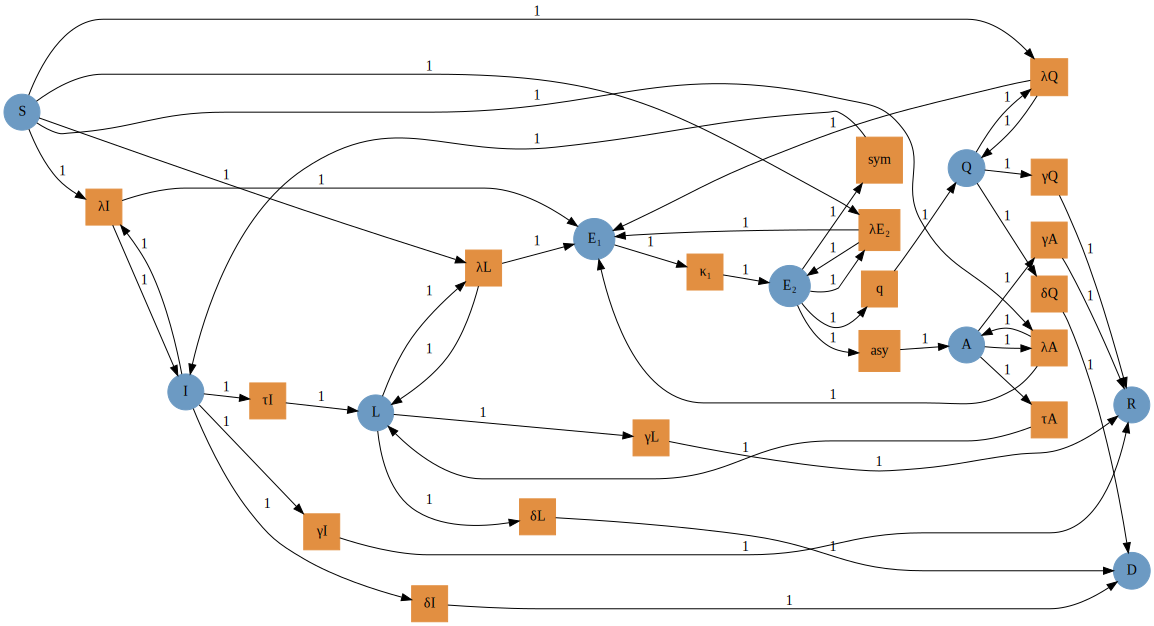

In [4]:
compartmental_system = oapply(compartments, Dict(
 :expose_to_symptomatic => exposure_petri(:S, :I, :E₁, :λI),
 :expose_to_asymptomatic => exposure_petri(:S, :A, :E₁, :λA),
 :expose_to_quarantined => exposure_petri(:S, :Q, :E₁, :λQ),
 :expose_to_isolated => exposure_petri(:S, :L, :E₁, :λL),
 :expose_to_presymptomatic => exposure_petri(:S, :E₂, :E₁, :λE₂),

 :infect => spontaneous_petri(:E₁, :E₂, :κ₁),

 :neutralize => spontaneous_petri(:E₂, :A, :asy),
 :worsen => spontaneous_petri(:E₂, :I, :sym),
 :quarantine => spontaneous_petri(:E₂, :Q, :q),

 :isolate_to_asymptomatic => spontaneous_petri(:A,:L, :τA),
 :isolate_to_symptomatic => spontaneous_petri(:I,:L, :τI),

 :recover_from_asymptomatic => spontaneous_petri(:A,:R, :γA),
 :recover_from_symptomatic => spontaneous_petri(:I,:R, :γI),
 :recover_from_quarantined => spontaneous_petri(:Q,:R, :γQ),
 :recover_from_isolated => spontaneous_petri(:L,:R, :γL),

 :die_from_symptomatic => spontaneous_petri(:I,:D, :δI),
 :die_from_quarantined => spontaneous_petri(:Q,:D, :δQ),
 :die_from_isolated => spontaneous_petri(:L,:D, :δL),
))

Graph(compartmental_system)

In [5]:
pops = open(parse_json, "../../configs/population.json")
state = LVector(
    S = pops["susceptible"],
    E₁ = pops["exposed"],
    E₂ = pops["presymptomatic"],
    I = pops["symptomatic_infected"],
    A = pops["asymptomatic_infected"],
    Q = pops["quarantined"],
    L = pops["isolated"],
    R = pops["recovered"],
    D = pops["death"],
  )


params = open(parse_json, "../../configs/params.json")
parameters = LVector(
    λI = params["βI"],
    λA = params["βA"],
    λQ = params["βQ"],
    λL = params["βL"], 
    λE₂ = params["βE₂"], 
    m = params["m"],
    ζ = params["ζ"],
    κ₁ = params["κ₁"], 
    κ₂ = params["κ₂"], 
    asy = params["ρ"],
    sym = params["q"],
    q = params["q"],
    τI = params["τI"],
    τA = params["τA"],
    γI = params["γI"],
    γA = params["γA"],
    γQ = params["γQ"],
    γL = params["γL"],
    δI = params["δI"],
    δL = params["δL"],
    δQ = params["δQ"],
  )

tspan = (0.0, 365.0)

(0.0, 365.0)

In [6]:
prob = ODEProblem(vectorfield(apex(compartmental_system)), state, tspan, parameters)
sol = solve(prob, Rosenbrock23());

In [7]:
solve_day(day) = last(
    solve(
      ODEProblem(vectorfield(apex(compartmental_system)), state, (day-1, day), parameters),
      Rosenbrock23()
    ).u
)

solve_day(5)

9-element LArray{Float64, 1, Vector{Float64}, (:S, :E₁, :E₂, :I, :A, :Q, :L, :R, :D)}:
  :S => 1.2817644386234017e-38
 :E₁ => 1.2838166808060001e8
 :E₂ => 1.647839389223188e7
  :I => 5.176182086596001e6
  :A => 4.83631200049481e6
  :Q => 7.084956064131199e6
  :L => 502703.8580751145
  :R => 2.2262537954656505e6
  :D => 2930.2224051838157